In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from fastai.vision.all import *
import torch
import os
import ast
import cv2
import tqdm
from sklearn.model_selection import train_test_split as tts 
from torchvision import transforms, utils
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
gc.collect()

16

# Checking Split

In [4]:
# Specify the paths to the training and test sets
training_path = "../input/fruits/fruits-360_dataset/fruits-360/Training"
test_path = "../input/fruits/fruits-360_dataset/fruits-360/Test"

# Function to count the number of samples in a directory
def count_samples(directory_path):
    return sum([len(files) for _, _, files in os.walk(directory_path)])

# Count samples in the training and test sets
num_training_samples = count_samples(training_path)
num_test_samples = count_samples(test_path)

# Calculate the split ratio
split_ratio = num_test_samples / (num_training_samples + num_test_samples)

# Print the results
print(f"Number of training samples: {num_training_samples}")
print(f"Number of test samples: {num_test_samples}")
print(f"Split ratio: {split_ratio:.2%}")


Number of training samples: 67692
Number of test samples: 22688
Split ratio: 25.10%


# Preparing Train, Test, Validation CSVs

In [5]:
class DatasetCSVs:
    
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.load_data()
        self.split_data()
        self.add_features()
        self.save_to_csv()

    def load_data(self):
        file_paths = []
        labels = []

        #iterating through the folders
        for folder in ["Training", "Test"]:
            folder_path = os.path.join(self.base_dir, folder)
            
            #iterating through class folders within Training & Testing folders
            for class_folder in os.listdir(folder_path):
                class_path = os.path.join(folder_path, class_folder)
                
                
                #iterating through image files
                for image_file in os.listdir(class_path):
                    file_path = os.path.join(class_path, image_file)
                    file_paths.append(file_path)
                    
                    #dropping everything after the first word in the labels, for example "Apple Golden 2", and "Apple Granny Smith" would just become labeled as "apple"
                    base_label = class_folder.lower().split('_')[0].strip().split()[0]
                    labels.append(base_label)
                    
        #Creating a dataframe with file paths and labels
        self.data_frame = pd.DataFrame({'file_path': file_paths, 'label': labels})

    def split_data(self):
        
        #Splitting the data in a 70-20-10 split for Training, Validation. and Testing
        train_ratio = 0.7
        validation_ratio = 0.2
        test_ratio = 0.1

        #splitting off training set
        train_data_frame, test_and_val_data_frame = tts(self.data_frame, test_size=1 - train_ratio, random_state=42)
        #splitting test and validation tests
        validation_data_frame, test_data_frame = tts(test_and_val_data_frame, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)

        self.train_data_frame = train_data_frame
        self.validation_data_frame = validation_data_frame
        self.test_data_frame = test_data_frame

    #adding the features "Count" and "Absolute path"
    def add_features(self):
        for df in [self.train_data_frame, self.validation_data_frame, self.test_data_frame]:
            df['count'] = df.groupby('label').cumcount() + 1
            df['absolute_location'] = df['file_path'].apply(os.path.abspath)

    #saving to csv files
    def save_to_csv(self):
        self.train_data_frame.to_csv("train_dataset.csv", index=False)
        self.test_data_frame.to_csv("test_dataset.csv", index=False)
        self.validation_data_frame.to_csv("validation_dataset.csv", index=False)
        print("CSV files for Training, Test, and Validation created")

        print(f"Training split ratio: {len(self.train_data_frame) / len(self.data_frame):.2%}")
        print(f"Validation split ratio: {len(self.validation_data_frame) / len(self.data_frame):.2%}")
        print(f"Testing split ratio: {len(self.test_data_frame) / len(self.data_frame):.2%}")

# Specify the base directory of the dataset
base_dir = "../input/fruits/fruits-360_dataset/fruits-360"

# Create an instance of DatasetCSVs
dataset_csvs = DatasetCSVs(base_dir)

CSV files for Training, Test, and Validation created
Training split ratio: 70.00%
Validation split ratio: 20.00%
Testing split ratio: 10.00%


In [6]:
pd.read_csv("train_dataset.csv")

,file_path,label,count,absolute_location
0,../input/fruits/fruits-360_dataset/fruits-360/Training/Potato Sweet/6_100.jpg,potato,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Potato Sweet/6_100.jpg
1,../input/fruits/fruits-360_dataset/fruits-360/Training/Grape White 4/127_100.jpg,grape,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Grape White 4/127_100.jpg
2,../input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/46_100.jpg,tomato,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/46_100.jpg
3,../input/fruits/fruits-360_dataset/fruits-360/Test/Peach Flat/72_100.jpg,peach,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Peach Flat/72_100.jpg
4,../input/fruits/fruits-360_dataset/fruits-360/Training/Pear Red/125_100.jpg,pear,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Pear Red/125_100.jpg
...,...,...,...,...
63260,../input/fruits/fruits-360_dataset/fruits-360/Training/Pear Monster/285_100.jpg,pear,4751,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Pear Monster/285_100.jpg
63261,../input/fruits/fruits-360_dataset/fruits-360/Training/Cherry Rainier/r_145_100.jpg,cherry,3243,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Cherry Rainier/r_145_100.jpg
63262,../input/fruits/fruits-360_dataset/fruits-360/Test/Onion White/r_167_100.jpg,onion,1226,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Onion White/r_167_100.jpg
63263,../input/fruits/fruits-360_dataset/fruits-360/Training/Grapefruit White/107_100.jpg,grapefruit,910,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Grapefruit White/107_100.jpg


# Count per label

In [7]:
pd.read_csv("test_dataset.csv")

,file_path,label,count,absolute_location
0,../input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/r_33_100.jpg,tomato,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/r_33_100.jpg
1,../input/fruits/fruits-360_dataset/fruits-360/Test/Maracuja/104_100.jpg,maracuja,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Maracuja/104_100.jpg
2,../input/fruits/fruits-360_dataset/fruits-360/Training/Limes/10_100.jpg,limes,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Limes/10_100.jpg
3,../input/fruits/fruits-360_dataset/fruits-360/Training/Apple Granny Smith/170_100.jpg,apple,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Apple Granny Smith/170_100.jpg
4,../input/fruits/fruits-360_dataset/fruits-360/Training/Granadilla/151_100.jpg,granadilla,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Granadilla/151_100.jpg
...,...,...,...,...
9034,../input/fruits/fruits-360_dataset/fruits-360/Training/Watermelon/89_100.jpg,watermelon,55,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Watermelon/89_100.jpg
9035,../input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/r_147_100.jpg,tomato,675,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Tomato 1/r_147_100.jpg
9036,../input/fruits/fruits-360_dataset/fruits-360/Training/Pear Kaiser/97_100.jpg,pear,637,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Pear Kaiser/97_100.jpg
9037,../input/fruits/fruits-360_dataset/fruits-360/Training/Pomelo Sweetie/r_54_100.jpg,pomelo,69,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Pomelo Sweetie/r_54_100.jpg


In [8]:
pd.read_csv("validation_dataset.csv")

,file_path,label,count,absolute_location
0,../input/fruits/fruits-360_dataset/fruits-360/Training/Grapefruit White/r_197_100.jpg,grapefruit,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Grapefruit White/r_197_100.jpg
1,../input/fruits/fruits-360_dataset/fruits-360/Training/Maracuja/254_100.jpg,maracuja,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Maracuja/254_100.jpg
2,../input/fruits/fruits-360_dataset/fruits-360/Training/Grape White/133_100.jpg,grape,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Grape White/133_100.jpg
3,../input/fruits/fruits-360_dataset/fruits-360/Training/Grape White 2/150_100.jpg,grape,2,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Grape White 2/150_100.jpg
4,../input/fruits/fruits-360_dataset/fruits-360/Test/Cucumber Ripe 2/r_185_100.jpg,cucumber,1,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Cucumber Ripe 2/r_185_100.jpg
...,...,...,...,...
18071,../input/fruits/fruits-360_dataset/fruits-360/Test/Kohlrabi/17_100.jpg,kohlrabi,129,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Kohlrabi/17_100.jpg
18072,../input/fruits/fruits-360_dataset/fruits-360/Training/Onion Red Peeled/r2_62_100.jpg,onion,378,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Onion Red Peeled/r2_62_100.jpg
18073,../input/fruits/fruits-360_dataset/fruits-360/Training/Cocos/r_291_100.jpg,cocos,136,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Cocos/r_291_100.jpg
18074,../input/fruits/fruits-360_dataset/fruits-360/Training/Cocos/85_100.jpg,cocos,137,/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Cocos/85_100.jpg


In [9]:
gc.collect()

0

# Visualizing some images

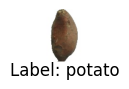

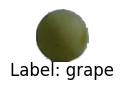

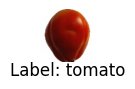

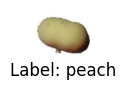

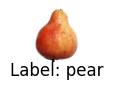

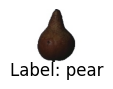

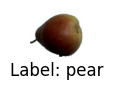

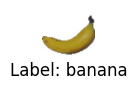

In [10]:
def visualize_images(data_frame, num_images=8):
    for i in range(num_images):
        file_path = data_frame['file_path'].iloc[i]
        label = data_frame['label'].iloc[i]
        image = Image.open(file_path)
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}", y=-0.40)        
        plt.axis('off')
        plt.show()

# Visualize images from the training set
visualize_images(dataset_csvs.train_data_frame)

# Utility Function

In [11]:
def load_and_process_csv(csv_path, target_size=(256, 256)):
    df = pd.read_csv(csv_path)
    
    # Rename 'file_path' column to 'image'
    df = df.rename(columns={"file_path": "image"})
    
    # Convert image paths to NumPy arrays using PIL and resize
    df['image'] = df['image'].apply(lambda x: np.array(Image.open(x).resize(target_size)))
    
    # You may need to further preprocess or normalize the images depending on your requirements
    
    return df[['image', 'label']]


# Training Data

In [12]:
def data(train_csv_path, validation_csv_path, test_csv_path):
    # Load and process training CSV
    df_train = load_and_process_csv(train_csv_path)
    
    # Load and process validation CSV
    df_validation = load_and_process_csv(validation_csv_path)
    
    # Load and process test CSV
    df_test = load_and_process_csv(test_csv_path)
    
    return df_train, df_validation, df_test

# Specify the file paths for the CSVs
train_csv_path = "train_dataset.csv"
validation_csv_path = "validation_dataset.csv"
test_csv_path = "test_dataset.csv"

# Call the data function
df_train, df_validation, df_test = data(train_csv_path, validation_csv_path, test_csv_path)



In [13]:
# Display the first few rows of each DataFrame
print("Training DataFrame:")
print(df_train.head())

print("\nValidation DataFrame:")
print(df_validation.head())

print("\nTesting DataFrame:")
print(df_test.head())

Training DataFrame:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     image  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 2

In [14]:
X_train, y_train = df_train["image"], df_train["label"]
X_validation, y_validation = df_validation["image"], df_validation["label"]
X_test, y_test = df_test["image"], df_test["label"]

In [15]:
dftrain = pd.DataFrame({"image": X_train, "label": y_train})
dftest = pd.DataFrame({"image": X_test, "label": y_test})
dfvalidation = pd.DataFrame({"image": X_validation, "label": y_validation})

In [16]:
dftrain.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",potato
1,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",grape
2,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",tomato
3,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",peach
4,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",pear


In [17]:
dftest.head()

,image,label
0,"[[[255, 254, 255], [255, 254, 255], [255, 254, 255], [255, 254, 255], [255, 254, 255], [255, 255, 253], [254, 255, 253], [253, 255, 254], [251, 255, 255], [251, 255, 255], [251, 255, 255], [251, 255, 255], [251, 255, 255], [251, 255, 255], [251, 255, 255], [251, 255, 255], [252, 255, 255], [253, 255, 255], [254, 255, 255], [255, 255, 255], [255, 255, 253], [255, 255, 251], [255, 255, 250], [255, 255, 250], [255, 255, 250], [255, 255, 250], [255, 255, 251], [255, 255, 251], [255, 255, 252], [255, 255, 253], [255, 255, 254], [255, 254, 255], [255, 254, 255], [254, 255, 255], [254, 255, 255],...",tomato
1,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",maracuja
2,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",limes
3,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",apple
4,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255],...",granadilla


In [18]:
del X_train, X_test, y_train, y_test 
gc.collect()

6385

In [19]:
dftrain.image.iloc[0].shape

(256, 256, 3)

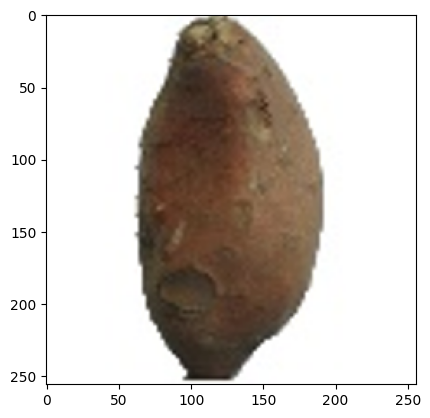

In [20]:
plt.imshow(dftrain.image.iloc[0])

In [21]:
unique=dftrain.label.unique()
unique1=unique
unique=enumerate(unique)
legend={}
for i, j in unique:
    legend[j]=i
del unique
gc.collect()

50

In [22]:
class trainingdf(torch.utils.data.Dataset):
    def __init__(self, df, class2index):
        self.DF = df
        self.class2index = class2index

    def __len__(self):
        return self.DF.shape[0]

    def __getitem__(self, index):
        image = self.DF.image.iloc[index]
        label = self.DF.label.iloc[index]
        label = self.class2index[label]
        return image, label


In [23]:
unique_labels = dftrain['label'].unique()
class2index = {label: index for index, label in enumerate(unique_labels)}
dftrain=trainingdf(dftrain, class2index)
dftest=trainingdf(dftest, class2index)


In [24]:
gc.collect()

0

# Training Model

In [25]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import copy

In [26]:
dls_tr=DataLoader(dftrain,batch_size=4*2,shuffle=True,num_workers=0)


In [27]:
dls_te=DataLoader(dftest,batch_size=4*2,shuffle=True,num_workers=0)


In [28]:
dls_te.batch_size


8

In [29]:
for i,j in dls_tr:
    break

In [30]:
i.shape


torch.Size([8, 256, 256, 3])

47


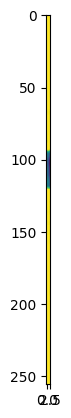

In [31]:
plt.imshow(i[0][0])
print(j[0].item())


In [32]:
model = torchvision.models.resnet50(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [33]:
device

device(type='cuda')

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad = True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000, 12000, 18000], gamma=0.5)

In [35]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 340)
model = model.to(device)

In [36]:
dataloaders={"train":dls_tr,"valid":dls_te}

In [37]:
del dls_tr,dls_te
gc.collect()

21

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
             #global inputs
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs/255)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    del best_acc, epoch_loss, epoch_acc
    gc.collect()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [39]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs/255)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                ax.set_title(f'predicted: {decode_labels(j)}')
                plt.imshow(inputs.cpu().data[j][0])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

In [40]:
def squeeze_weights(m):
    m.weight.data = m.weight.data.sum(dim=1)[:,None]
    m.in_channels = 1

model.conv1.apply(squeeze_weights)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)